In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyref.fitting as fit

CPU_COUNT = os.cpu_count() | 8

In [2]:
from typing import Any

import numpy as np
import pandas as pd
from numba import njit  # type: ignore
from numpy import complexfloating
from numpy._typing import _64Bit
from numpy._typing._array_like import NDArray
from pandas.core.frame import DataFrame
from pyref.fitting.structure import Parameter, possibly_create_parameter
from pyref.fitting.structure import PXR_Component as Component
from scipy.interpolate import interp1d


@njit(cache=True, fastmath=True)
def _orientation_profile_core(
    total_thick,
    depth,
    characteristic_thickness,
    max_angle,
    initial_angle,
):
    thick = depth  # total_thick - depth
    return max_angle * (1 - np.exp(-thick / characteristic_thickness)) + initial_angle


def orientation_profile(
    total_thick, depth, characteristic_thickness, max_angle, initial_angle
):
    if np.isscalar(depth):
        return _orientation_profile_core(
            total_thick,
            depth,
            characteristic_thickness,
            max_angle,
            initial_angle,
        )

    depth_arr = np.asarray(depth, dtype=np.float64)
    return _orientation_profile_core(
        total_thick,
        depth_arr,
        characteristic_thickness,
        max_angle,
        initial_angle,
    )


class OrientationProfile(Component):
    def __init__(
        self,
        ooc: pd.DataFrame,
        total_thick,
        surface_roughness,
        density,
        characteristic_thickness,
        max_angle,
        initial_angle,
        energy,
        energy_offset: float = 0,
        name: str | None = None,
        microslab_max_thickness: float = 1,
    ):
        super(OrientationProfile, self).__init__(name=name)
        # Load the OOC data
        mask = (ooc["energy"] > energy - 1) & (ooc["energy"] < energy + 1)
        ooc = ooc[mask]
        self.n_xx = interp1d(ooc["energy"], ooc["n_xx"], bounds_error=False)
        self.n_ixx = interp1d(ooc["energy"], ooc["n_ixx"], bounds_error=False)
        self.n_zz = interp1d(ooc["energy"], ooc["n_zz"], bounds_error=False)
        self.n_izz = interp1d(ooc["energy"], ooc["n_izz"], bounds_error=False)
        self.energy = energy
        # Setup the parameters
        self.total_thick = possibly_create_parameter(total_thick, name="total_thick")
        self.surface_roughness = possibly_create_parameter(
            surface_roughness, name="surface_roughness"
        )
        self.density = possibly_create_parameter(density, name="density")
        self.characteristic_thickness = possibly_create_parameter(
            characteristic_thickness, name="characteristic_thickness"
        )
        self.max_angle = possibly_create_parameter(max_angle, name="max_angle")
        self.initial_angle = possibly_create_parameter(
            initial_angle, name="initial_angle"
        )
        self.energy_offset = possibly_create_parameter(
            energy_offset, name="energy_offset"
        )
        # Initialize the microslabs
        self.microslab_max_thickness = microslab_max_thickness
        # Load into the super class
        self._parameters = super().parameters
        self._parameters.extend(
            [
                self.total_thick,
                self.surface_roughness,
                self.density,
                self.characteristic_thickness,
                self.max_angle,
                self.initial_angle,
                self.energy_offset,
            ]
        )

    def varying_parameters(self):
        return [p for p in self._parameters if p.vary]

    @property
    def num_slabs(self) -> int:
        return int(
            np.ceil(float(self.total_thick.value) / self.microslab_max_thickness)
        )

    @property
    def slab_thick(self) -> float:
        return self.total_thick.value / self.num_slabs

    @property
    def dist(self) -> NDArray[np.float64]:
        return np.linspace(self.slab_thick, self.total_thick.value, self.num_slabs)

    @property
    def mid_points(self) -> NDArray[np.float64]:
        return np.linspace(
            self.slab_thick / 2,
            self.total_thick.value - self.slab_thick / 2,
            self.num_slabs,
        )

    @property
    def parameters(self) -> Any:
        return self._parameters

    def orientation(
        self,
        depth: NDArray[np.float64] | float,
    ) -> NDArray[np.float64] | float:
        t = self.total_thick.value - depth
        return orientation_profile(
            self.total_thick.value,
            t,
            self.characteristic_thickness.value,
            self.max_angle.value,
            self.initial_angle.value,
        )

    def get_energy(self) -> float:
        return float(self.energy) + float(self.energy_offset.value)

    @property
    def n(self) -> NDArray[complexfloating[_64Bit, _64Bit]]:
        """
        Optical constants of the material.

        Returns
        -------
        n : np.ndarray
            Optical constants of the material.
        """
        e = self.get_energy()
        return np.array(
            [
                [self.n_xx(e) + self.n_ixx(e) * 1j, 0],
                [0, self.n_zz(e) + self.n_izz(e) * 1j],
            ],
            dtype=np.complex128,
        )

    def tensor(
        self,
        energy: float | None = None,
    ) -> NDArray[complexfloating[_64Bit, _64Bit]]:
        if energy is None:
            energy = self.get_energy()
        depth_arr = self.mid_points
        ori = self.orientation(depth_arr)
        n = self.n

        c = np.square(np.cos(ori))
        s = np.square(np.sin(ori))
        xx = (n[0, 0] * (1 + c) + n[1, 1] * s) / 2
        zz = n[0, 0] * s + n[1, 1] * c

        tensor = np.zeros((depth_arr.size, 3, 3), dtype=np.complex128)
        tensor[:, 0, 0] = xx
        tensor[:, 1, 1] = xx
        tensor[:, 2, 2] = zz
        return tensor

    @property
    def iso(self) -> NDArray[np.float64]:
        return np.trace(self.tensor(), axis1=1, axis2=2)

    @property
    def delta(self) -> NDArray[np.float64]:
        return np.real(self.iso)

    @property
    def beta(self) -> NDArray[np.float64]:
        return np.imag(self.iso)

    def slabs(self, structure=None) -> NDArray[np.float64]:
        slabs = np.zeros((self.num_slabs, 4))
        slabs[..., 0] = self.slab_thick
        slabs[..., 1] = self.delta
        slabs[..., 2] = self.beta
        slabs[0, 3] = self.surface_roughness.value
        return slabs


ooc = pd.read_csv("optical_constants.csv")


<Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>

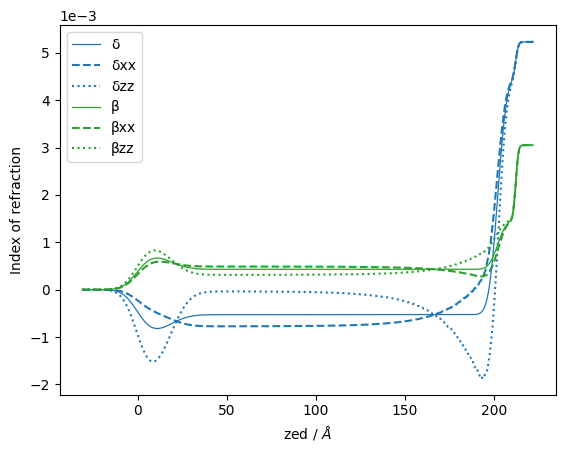

In [3]:
op = dict[str, Any](
    ooc=ooc,
    density=1.4,
    name="orientation_profile",
    total_thick=184,
    surface_roughness=8.5,
    characteristic_thickness=21,
    max_angle=0.95,
    initial_angle=0.18,
)
sub = dict[str, Any](
    density=2.44,
    energy_offset=0,
    thick=0,
    rough=1.2,
)
oxide = dict[str, Any](
    density=2.15,
    energy_offset=0,
    thick=10.1,
    rough=4,
)
surf = dict[str, Any](
    density=1.8,
    energy_offset=0,
    thick=18,
    rotation=0.78,
    rough=6.5,
)
vac = dict[str, Any](
    density=0,
    energy_offset=0,
    thick=0,
    rough=0,
)


def substrate(energy, **kwargs):
    """Substrate."""
    sub = kwargs.copy()
    # Use .pop with default values to avoid KeyError
    _struct = {"thick": sub.pop("thick", 0), "rough": sub.pop("rough", 0)}
    slab = fit.MaterialSLD("Si", **sub, energy=energy, name=f"Substrate_{energy}")(
        **_struct
    )
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=True, bounds=(2, 3))
    return slab


def sio2(energy, **kwargs):
    """SiO2."""
    oxide = kwargs.copy()
    _struct = {"thick": oxide.pop("thick", 10.1), "rough": oxide.pop("rough", 4)}
    slab = fit.MaterialSLD("SiO2", **oxide, energy=energy, name=f"Oxide_{energy}")(
        **_struct
    )
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=True, bounds=(1, 2.3))
    return slab


def vacuum(energy, **kwargs):
    """Vacuum."""
    vac = kwargs.copy()
    _struct = {"thick": vac.pop("thick", 0), "rough": vac.pop("rough", 0)}
    slab = fit.MaterialSLD("", **vac, energy=energy, name=f"Vacuum_{energy}")(**_struct)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def surface(energy, **kwargs):
    """Surface."""
    surf = kwargs.copy()
    name = f"Surface_{energy}"
    _struct = {"thick": surf.pop("thick", 3.3), "rough": surf.pop("rough", 8.5)}
    slab = fit.UniTensorSLD(ooc, **surf, energy=energy, name=name)(**_struct)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 2))
    slab.thick.setp(vary=True, bounds=(0, 25))
    slab.rough.setp(vary=True, bounds=(0, 20))
    return slab


def profile(energy, **kwargs):
    op = kwargs.copy()
    _profile = OrientationProfile(
        **op,
        energy=energy,
    )
    _profile.surface_roughness.setp(vary=True, bounds=(0, 20))
    _profile.characteristic_thickness.setp(vary=True, bounds=(0, 50))
    _profile.max_angle.setp(vary=True, bounds=(np.radians(55), np.pi / 2))
    _profile.initial_angle.setp(vary=True, bounds=(0, np.pi / 2))
    _profile.total_thick.setp(vary=True, bounds=(150, 200))
    _profile.density.setp(vary=True, bounds=(1.2, 1.6))
    _profile.energy_offset.setp(vary=True, bounds=(-0.3, 0.3))
    return _profile


stack = (
    vacuum(283.7, **vac)
    | surface(283.7, **surf)
    | profile(283.7, **op)
    | sio2(283.7, **oxide)
    | substrate(283.7, **sub)
)
stack.plot()

In [4]:
def load_reflectivity_dataset(filename):
    """
    Load reflectivity dataset from a parquet file.

    Parameters
    ----------
    filename : str
        Input filename (should be a .parquet file)

    Returns
    -------
    dict
        Dictionary containing XrayReflectDataset objects with energy keys
    """
    import polars as pl

    # Load the DataFrame
    df_load = pl.read_parquet(filename)

    # Reconstruct the data dictionary
    data_reconstructed = {}

    # Group by energy
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]  # Extract energy value from the group key tuple
        #  If the R - dR is negative or zero, drop the point
        diff = group_data["R"] - group_data["dR"]
        mask = diff > 0
        group_data = group_data.filter(mask)

        # Extract arrays
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = group_data["dR"].to_numpy()

        # Create XrayReflectDataset
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset

    print(f"Dataset loaded from {filename}")
    return data_reconstructed


loaded_data = load_reflectivity_dataset("../fitting/reflectivity_data.parquet")

Dataset loaded from ../fitting/reflectivity_data.parquet


In [5]:
op = dict[str, Any](
    ooc=ooc,
    density=stack.components[2].density.value,
    total_thick=stack.components[2].total_thick.value,
    surface_roughness=stack.components[2].surface_roughness.value,
    characteristic_thickness=stack.components[2].characteristic_thickness.value,
    max_angle=stack.components[2].max_angle.value,
    initial_angle=stack.components[2].initial_angle.value,
    energy_offset=stack.components[2].energy_offset.value,
    name="orientation_profile",
)
for i, layer in enumerate([vac, surf, op, oxide, sub]):
    fit_stack = stack.components[i]
    if "thick" in layer:
        layer["thick"] = fit_stack.thick.value
    if "rough" in layer:
        layer["rough"] = fit_stack.rough.value
    if "density" in layer:
        layer["density"] = fit_stack.sld.density.value
    if "rotation" in layer:
        layer["rotation"] = fit_stack.sld.rotation.value
    if i == 2:
        layer["total_thick"] = fit_stack.total_thick.value
        layer["surface_roughness"] = fit_stack.surface_roughness.value
        layer["characteristic_thickness"] = fit_stack.characteristic_thickness.value
        layer["max_angle"] = fit_stack.max_angle.value
        layer["initial_angle"] = fit_stack.initial_angle.value

<Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>

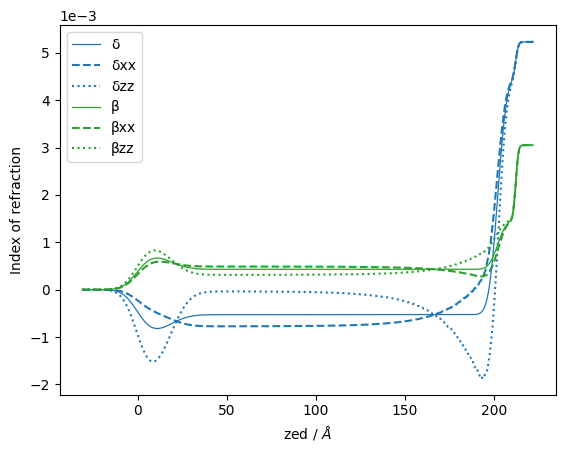

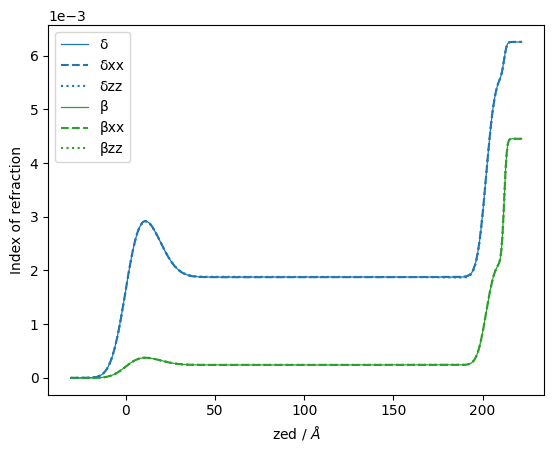

In [6]:
def stack_builder(energy: float):
    return (
        vacuum(energy, **vac)  # type: ignore
        | surface(energy, **surf)  # type: ignore
        | profile(energy, **op)  # type: ignore
        | sio2(energy, **oxide)  # type: ignore
        | substrate(energy, **sub)  # type: ignore
    )


stack_builder(283.7).plot()
stack_builder(250).plot()

In [7]:
def model_builder(energy: float) -> fit.ReflectModel:
    stack = stack_builder(energy)
    model = fit.ReflectModel(stack, energy=energy, pol="sp")
    model.scale_p.setp(value=1, vary=True, bounds=(0.5, 2))
    model.scale_s.setp(value=1, vary=True, bounds=(0.5, 2))
    model.theta_offset_p.setp(value=0, vary=True, bounds=(-0.5, 0.5))
    model.theta_offset_s.setp(value=0, vary=True, bounds=(-0.5, 0.5))
    model.energy_offset.setp(value=0, vary=True, bounds=(-0.3, 0.3))
    # Ensure every slab is constrained to the model energy_offset
    for i, component in enumerate(stack.components):
        if hasattr(component.sld, "energy_offset"):
            component.sld.energy_offset.setp(constraint=model.energy_offset, vary=None)
        elif hasattr(component, "energy_offset"):
            component.energy_offset.setp(constraint=model.energy_offset, vary=None)
    return model


def constraint_builder(models: dict[str, fit.ReflectModel], constraining_energy: float):
    constraining_model = models[str(constraining_energy)]
    for energy, model in models.items():
        energy = float(energy)
        if energy == constraining_energy:
            continue
        for i, component in enumerate(model.structure.components):
            if hasattr(component, "thick"):
                component.thick.setp(
                    constraint=constraining_model.structure.components[i].thick,
                    vary=None,
                )
                component.rough.setp(
                    constraint=constraining_model.structure.components[i].rough,
                    vary=None,
                )
                if hasattr(component, "density"):
                    component.density.setp(
                        constraint=constraining_model.structure.components[
                            i
                        ].sld.density,
                        vary=None,
                    )
                if hasattr(component, "rotation"):
                    component.rotation.setp(
                        constraint=constraining_model.structure.components[
                            i
                        ].sld.rotation,
                        vary=None,
                    )
            else:
                component.total_thick.setp(
                    constraint=constraining_model.structure.components[i].total_thick,
                    vary=None,
                )
                component.surface_roughness.setp(
                    constraint=constraining_model.structure.components[
                        i
                    ].surface_roughness,
                    vary=None,
                )
                component.characteristic_thickness.setp(
                    constraint=constraining_model.structure.components[
                        i
                    ].characteristic_thickness,
                    vary=None,
                )
                component.max_angle.setp(
                    constraint=constraining_model.structure.components[i].max_angle,
                    vary=None,
                )
                component.initial_angle.setp(
                    constraint=constraining_model.structure.components[i].initial_angle,
                    vary=None,
                )
    return models


models = {
    str(energy): model_builder(energy)
    for energy in [250.0, 283.7, 284.2, 285.1, 287.0, 289.0]
}
constraint_builder(models, 283.7)

{'250.0': ReflectModel(Structure(components=[Slab(Parameter(value=0.0, name='Vacuum_250.0_thick', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=Parameter(value=0.0, name='Vacuum_283.7_thick', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=None)), MaterialSLD('', Parameter(value=0.0, name='Vacuum_250.0_rho', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=None),energy=250.0,  name='Vacuum_250.0'), Parameter(value=0.0, name='Vacuum_250.0_rough', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=Parameter(value=0.0, name='Vacuum_283.7_rough', vary=False, bounds=Interval(lb=0.0, ub=0.0), constraint=None)), name='Vacuum_250.0',, Slab(Parameter(value=18.0, name='Surface_250.0_thick', vary=False, bounds=Interval(lb=0.0, ub=25.0), constraint=Parameter(value=18.0, name='Surface_283.7_thick', vary=True, bounds=Interval(lb=0.0, ub=25.0), constraint=None)), Index of Refraction = (name='Surface_250.0'), Parameter(value=6.5, name='Surface_250.0_rough', vary=False, bo

In [8]:
def x0(fitter):
    o = fitter.objective
    p0 = o.varying_parameters()
    return np.array([o.value for o in p0])


def bounds(p, override_chain=False):
    if np.shape(p.chain) == () or override_chain:
        return ((p.value - p.stderr) * 0.8, (p.value + p.stderr) * 1.2)
    else:
        return (p.chain[-1].min() * 0.8, p.chain[-1].max() * 1.2)


def update_bounds(fitter, override_chain=False):
    p0 = fitter.objective.varying_parameters()
    for p in p0:
        if p.name.split("_")[-1] in ["rotation"]:
            continue
        # Update the bounds
        p.setp(bounds=bounds(p, override_chain))

In [9]:
from refnx._lib.emcee.moves import DEMove, DESnookerMove

move: list[tuple[DEMove, float] | tuple[DESnookerMove, float]] = [
    (DEMove(), 0.8),
    (DESnookerMove(), 0.2),
]

In [10]:
internal_energies = [250.0, 283.7, 284.2, 285.1, 287.0, 289.0]

internal_objectives = [
    fit.AnisotropyObjective(
        models[str(energy)],
        loaded_data[str(energy)],
        transform=fit.Transform("logY"),
        logp_anisotropy_weight=0.5,
    )
    for energy in [250.0, 283.7, 284.2, 285.1, 287.0, 289.0]
]
# Construct a global objective from the internal objectives
global_objective = fit.GlobalObjective(internal_objectives)

# Fit the global objective
fitter = fit.CurveFitter(global_objective, moves=move)

In [ ]:
fitter.fit("differential_evolution", workers=CPU_COUNT // 3, updating="deferred")
update_bounds(fitter, override_chain=True)
fitter.fit("L-BFGS-B")
update_bounds(fitter, override_chain=True)
fitter.fit(
    "differential_evolution", workers=CPU_COUNT // 3, updating="deferred", x0=x0(fitter)
)
update_bounds(fitter, override_chain=True)

13137.641298561073: : 16it [50:17, 174.55s/it]

In [ ]:
fitter.initialise("jitter", random_state=12345)
fitter.sample(200)
update_bounds(fitter)
fitter.reset()
fitter.sample(1000)
print(global_objective.varying_parameters())

In [ ]:
plt.plot(-fitter.logpost, alpha=0.5)
plt.show()

In [ ]:
global_objective.plot()
plt.show()
global_objective.corner()
plt.show()

In [ ]:
import pickle

# save in pickle
with open("fitting_results_profile_4.pkl", "wb") as f:
    pickle.dump(global_objective, f)
